In [1]:
# Cell 1: Imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from PIL import Image

print("TensorFlow version:", tf.__version__)

2025-10-07 21:03:01.560339: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-07 21:03:01.749713: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759870981.833334   27503 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759870981.855201   27503 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1759870981.999543   27503 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

TensorFlow version: 2.19.0


In [2]:
# Cell 2: Configuration
# Data parameters
IMG_SIZE = 128  # The paper uses images up to 128x128
CHANNELS = 1     # Grayscale images
BATCH_SIZE = 32  # The paper used 128, but we have less data, so a smaller batch is better
NUM_CLASSES = 2  # 0 for 'as_cast', 1 for 'deformed'

# Training parameters
EPOCHS = 800  # As used in the paper [cite: 266]
LATENT_DIM = 128 # Size of the noise vector (z)

# Model parameters (from paper's Table 3 and text) 
LEARNING_RATE = 0.0002
CRITIC_UPDATES = 4 # Number of times critic is updated per generator update
LEAKY_RELU_SLOPE = 0.2
CONTRASTIVE_LOSS_WEIGHT = 1.0 # Lambda for the contrastive loss
CONTRASTIVE_TEMP = 0.1       # Temperature parameter 't' in the contrastive loss [cite: 240]

In [3]:
# Cell 3: Data Loading Function
DATA_DIR = "./trial_1/" # IMPORTANT: Change this to your actual data path

def load_and_preprocess_data(data_dir):
    all_images = []
    all_labels = []
    
    class_names = sorted(os.listdir(data_dir))
    
    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        if os.path.isdir(class_dir):
            image_paths = glob.glob(os.path.join(class_dir, '*.*'))
            for img_path in image_paths:
                try:
                    img = Image.open(img_path).convert('L') # Convert to grayscale
                    img = img.resize((IMG_SIZE, IMG_SIZE))
                    img_array = np.array(img)
                    
                    # Normalize images to [-1, 1] as done in the paper [cite: 293]
                    img_array = (img_array.astype(np.float32) - 127.5) / 127.5
                    
                    all_images.append(img_array)
                    all_labels.append(label)
                except Exception as e:
                    print(f"Could not process image {img_path}: {e}")
                    
    all_images = np.array(all_images)[..., np.newaxis] # Add channel dimension
    all_labels = np.array(all_labels)
    
    return all_images, all_labels

images, labels = load_and_preprocess_data(DATA_DIR)
print(f"Loaded {len(images)} images.")
print("Image shape:", images.shape)
print("Labels shape:", labels.shape)
print("Unique labels and counts:", np.unique(labels, return_counts=True))

Loaded 32 images.
Image shape: (32, 128, 128, 1)
Labels shape: (32,)
Unique labels and counts: (array([0, 1]), array([21, 11]))


In [4]:
# Cell 4: Create tf.data.Dataset and Augmentation
# Data augmentation is crucial for small datasets like yours.
# The paper also augmented their data [cite: 292]
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
    ]
)

def prepare_dataset(images, labels):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.shuffle(buffer_size=len(images))
    
    # Apply augmentation and prepare batches
    dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

train_dataset = prepare_dataset(images, labels)

I0000 00:00:1759836824.505628    1855 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1768 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [3]:
# Cell 5: Self-Attention Layer
class SelfAttention(layers.Layer):
    """
    Self-attention layer as described in SAGAN (used in the paper). [cite: 90, 218]
    """
    def __init__(self, channels, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)
        self.channels = channels
        self.theta = layers.Conv2D(channels // 8, 1, padding='same', use_bias=False)
        self.phi = layers.Conv2D(channels // 8, 1, padding='same', use_bias=False)
        self.g = layers.Conv2D(channels // 2, 1, padding='same', use_bias=False)
        self.o = layers.Conv2D(channels, 1, padding='same', use_bias=False)
        self.gamma = tf.Variable(0., trainable=True, name='gamma')

    def call(self, inputs):
        shape = tf.shape(inputs)
        batch_size, height, width = shape[0], shape[1], shape[2]
        
        theta = self.theta(inputs)
        phi = self.phi(inputs)
        g = self.g(inputs)

        theta_reshaped = tf.reshape(theta, [batch_size, height * width, -1])
        phi_reshaped = tf.reshape(phi, [batch_size, height * width, -1])
        g_reshaped = tf.reshape(g, [batch_size, height * width, -1])

        attention = tf.matmul(theta_reshaped, phi_reshaped, transpose_b=True)
        attention = tf.nn.softmax(attention)

        o = tf.matmul(attention, g_reshaped)
        o = tf.reshape(o, [batch_size, height, width, self.channels // 2])
        o = self.o(o)
        
        return inputs + self.gamma * o

In [6]:
# Cell 6: Generator Model
def build_generator():
    # Noise input
    noise_input = layers.Input(shape=(LATENT_DIM,), name='noise_input')
    
    # Label input
    label_input = layers.Input(shape=(1,), name='label_input')
    
    # Embedding for the label, as described in the paper [cite: 251]
    label_embedding = layers.Embedding(NUM_CLASSES, LATENT_DIM, input_length=1)(label_input)
    label_embedding = layers.Flatten()(label_embedding)
    
    # Element-wise multiplication to condition the noise [cite: 254]
    model_input = layers.multiply([noise_input, label_embedding])
    
    # Start of the network based on Table 1 
    x = layers.Dense(4 * 4 * 512, use_bias=False)(model_input)
    x = layers.Reshape((4, 4, 512))(x)
    
    # Conv Transpose I
    x = layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=LEAKY_RELU_SLOPE)(x)
    
    # Conv Transpose II
    x = layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=LEAKY_RELU_SLOPE)(x)
    
    # Conv Transpose III
    x = layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=LEAKY_RELU_SLOPE)(x)
    
    # Self-Attention Layer [cite: 256]
    x = SelfAttention(channels=64)(x)
    
    # Conv Transpose IV
    x = layers.Conv2DTranspose(32, kernel_size=4, strides=2, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=LEAKY_RELU_SLOPE)(x)

    # Conv Transpose V (Output)
    x = layers.Conv2DTranspose(CHANNELS, kernel_size=4, strides=2, padding='same', use_bias=False)(x)
    # Tanh activation to scale output to [-1, 1] [cite: 258]
    output_image = layers.Activation('tanh', name='output_image')(x)
    
    model = keras.Model([noise_input, label_input], output_image)
    return model

generator = build_generator()
generator.summary()

/home/sapt/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/home/sapt/miniconda3/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ label_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 128)    │        256 │ label_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ noise_input         │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 128)       │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 128)       │          0 │ noise_input[0][0… │
│                     │                   │            │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 8192)      │  1,048,576 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 4, 4, 512) │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 8, 8, 256) │  2,097,152 │ reshape[0][0]     │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 8, 8, 256) │      1,024 │ conv2d_transpose… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 8, 8, 256) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 16, 16,    │    524,288 │ leaky_re_lu[0][0] │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 32, 32,    │    131,072 │ leaky_re_lu_1[0]… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ self_attention      │ (None, 32, 32,    │      5,120 │ leaky_re_lu_2[0]… │
│ (SelfAttention)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_3  │ (None, 64, 64,    │     32,768 │ self_attention[0

 Total params: 3,841,664 (14.65 MB)

 Trainable params: 3,840,704 (14.65 MB)

 Non-trainable params: 960 (3.75 KB)

In [7]:
# Cell 7: Critic Model
def build_critic():
    # Image input
    image_input = layers.Input(shape=(IMG_SIZE, IMG_SIZE, CHANNELS), name='image_input')
    
    # Label input
    label_input = layers.Input(shape=(1,), name='label_input')
    
    # Embedding for the label
    label_embedding = layers.Embedding(NUM_CLASSES, IMG_SIZE * IMG_SIZE)(label_input)
    label_embedding = layers.Reshape((IMG_SIZE, IMG_SIZE, 1))(label_embedding)

    # Concatenate label embedding with the image (one way of conditioning)
    # The paper injects it at a deeper layer, but this is a common and effective alternative.
    # Let's follow the paper's method.
    
    # Start of the network based on Table 2 
    # Conv I
    x = layers.Conv2D(64, kernel_size=4, strides=2, padding='same')(image_input)
    x = layers.LeakyReLU(alpha=LEAKY_RELU_SLOPE)(x)

    # Conv II
    x = layers.Conv2D(128, kernel_size=4, strides=2, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=LEAKY_RELU_SLOPE)(x)
    
    # Conv III
    x = layers.Conv2D(256, kernel_size=4, strides=2, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=LEAKY_RELU_SLOPE)(x)
    
    # Conv IV - where label information is injected
    x = layers.Conv2D(512, kernel_size=4, strides=2, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    features = layers.LeakyReLU(alpha=LEAKY_RELU_SLOPE)(x)
    
    # Paper's conditioning method [cite: 255]
    label_embedding_deep = layers.Embedding(NUM_CLASSES, 8*8*1)(label_input)
    label_embedding_deep = layers.Reshape((8, 8, 1))(label_embedding_deep)
    
    # Concatenate along the channel axis
    x = layers.Concatenate()([features, label_embedding_deep])

    # Conv V
    x = layers.Conv2D(512, kernel_size=4, strides=2, padding='same')(x)
    x = layers.LeakyReLU(alpha=LEAKY_RELU_SLOPE)(x)
    
    x = layers.Flatten()(x)
    
    # WGAN output (no activation)
    wgan_output = layers.Dense(1, name='wgan_output')(x)
    
    # Projection head for contrastive loss
    projection = layers.Dense(1024)(x)
    projection = layers.LeakyReLU(alpha=LEAKY_RELU_SLOPE)(projection)
    projection_output = layers.Dense(64, name='projection_output')(projection)
    
    model = keras.Model([image_input, label_input], [wgan_output, projection_output])
    return model

critic = build_critic()
critic.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │      1,088 │ image_input[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    131,072 │ leaky_re_lu_4[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_5       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │    524,288 │ leaky_re_lu_5[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      1,024 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_6       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 8, 8, 512) │  2,097,152 │ leaky_re_lu_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 512) │      2,048 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 1, 64)     │        128 │ label_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_7       │ (None, 8, 8, 512) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 8, 8, 1)   │          0 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 8, 8, 513) │          0 │ leaky_re_lu_7[0]… │
│ (Concatenate)       │                   │            │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 4, 4, 512) │  4,203,008 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_8       │ (None, 4, 4, 512) │          0 │ conv2d_8[0][0]  

 Total params: 15,423,745 (58.84 MB)

 Trainable params: 15,421,953 (58.83 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [8]:
# Cell 8: The CGAN Model with custom train_step

class CGAN(keras.Model):
    def __init__(self, generator, critic, latent_dim, num_classes, critic_updates, contrastive_loss_weight, contrastive_temp):
        super(CGAN, self).__init__()
        self.generator = generator
        self.critic = critic
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.critic_updates = critic_updates
        self.contrastive_loss_weight = contrastive_loss_weight
        self.temp = contrastive_temp

    def compile(self, g_optimizer, c_optimizer):
        super(CGAN, self).compile()
        self.g_optimizer = g_optimizer
        self.c_optimizer = c_optimizer
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")
        self.c_loss_metric = keras.metrics.Mean(name="c_loss")
        self.c_wgan_loss_metric = keras.metrics.Mean(name="c_wgan_loss")
        self.c_contrast_loss_metric = keras.metrics.Mean(name="c_contrast_loss")

    @property
    def metrics(self):
        return [self.g_loss_metric, self.c_loss_metric, self.c_wgan_loss_metric, self.c_contrast_loss_metric]

    # Implements the contrastive loss from Equation 3 in the paper [cite: 240]
    def _contrastive_loss(self, projections, labels):
        projections = tf.math.l2_normalize(projections, axis=1)
        # Create a matrix of dot products (cosine similarity)
        similarity_matrix = tf.matmul(projections, projections, transpose_b=True)
        
        # Create a mask for positive pairs (same label)
        label_matrix = tf.equal(labels, tf.transpose(labels))
        # Don't compare samples to themselves
        diag_mask = tf.cast(1.0 - tf.eye(tf.shape(labels)[0]), dtype=tf.bool)
        positive_mask = label_matrix & diag_mask
        
        # For each sample, the numerator is the sum of sims with other samples of the same class
        numerator = tf.exp(similarity_matrix / self.temp) * tf.cast(positive_mask, tf.float32)
        # Sum over all positive pairs for each sample
        numerator = tf.reduce_sum(numerator, axis=1, keepdims=True)
        
        # Denominator is the sum of sims with all other samples
        denominator = tf.exp(similarity_matrix / self.temp) * tf.cast(diag_mask, tf.float32)
        denominator = tf.reduce_sum(denominator, axis=1, keepdims=True)
        
        # The loss is -log(numerator / denominator)
        loss = -tf.math.log(numerator / (denominator + 1e-7))
        return tf.reduce_mean(loss)

    def train_step(self, data):
        real_images, real_labels = data
        batch_size = tf.shape(real_images)[0]
        
        # Train the Critic multiple times
        for _ in range(self.critic_updates):
            noise = tf.random.normal(shape=(batch_size, self.latent_dim))
            fake_images = self.generator([noise, real_labels], training=False)
            
            with tf.GradientTape() as tape:
                real_wgan_output, real_projections = self.critic([real_images, real_labels], training=True)
                fake_wgan_output, _ = self.critic([fake_images, real_labels], training=True)
                
                # Wasserstein loss [cite: 231]
                c_wgan_loss = tf.reduce_mean(fake_wgan_output) - tf.reduce_mean(real_wgan_output)
                
                # Contrastive loss (only on real samples) 
                c_contrast_loss = self._contrastive_loss(real_projections, real_labels)
                
                # Total critic loss
                c_loss = c_wgan_loss + self.contrastive_loss_weight * c_contrast_loss

            c_grads = tape.gradient(c_loss, self.critic.trainable_variables)
            self.c_optimizer.apply_gradients(zip(c_grads, self.critic.trainable_variables))

        # Train the Generator
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_labels = tf.random.uniform(shape=(batch_size, 1), minval=0, maxval=self.num_classes, dtype=tf.int32)
        
        with tf.GradientTape() as tape:
            generated_images = self.generator([noise, random_labels], training=True)
            gen_wgan_output, _ = self.critic([generated_images, random_labels], training=True)
            
            # Generator's Wasserstein loss
            g_loss = -tf.reduce_mean(gen_wgan_output)
        
        g_grads = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_variables))
        
        # Update metrics
        self.c_loss_metric.update_state(c_loss)
        self.c_wgan_loss_metric.update_state(c_wgan_loss)
        self.c_contrast_loss_metric.update_state(c_contrast_loss)
        self.g_loss_metric.update_state(g_loss)
        
        return {m.name: m.result() for m in self.metrics}

Starting training...
Epoch 1/800


I0000 00:00:1759836933.420690    2018 service.cc:152] XLA service 0x7fb5a80068b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759836933.420764    2018 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-10-07 11:35:33.695190: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-07 11:35:34.023950: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:108] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. random_uniform
I0000 00:00:1759836935.198558    2018 cuda_dnn.cc:529] Loaded cuDNN version 91002
2025-10-07 11:35:37.030056: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in 

1/1 ━━━━━━━━━━━━━━━━━━━━ 29s 29s/step - c_contrast_loss: 2.2204e-16 - c_loss: -111.9778 - c_wgan_loss: -111.9778 - g_loss: -140.2292
Epoch 2/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - c_contrast_loss: 5.5879e-09 - c_loss: -389.3157 - c_wgan_loss: -389.3157 - g_loss: -378.2823
Epoch 3/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - c_contrast_loss: 1.6764e-08 - c_loss: -747.8164 - c_wgan_loss: -747.8164 - g_loss: -635.3629
Epoch 4/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - c_contrast_loss: 9.3132e-09 - c_loss: -1073.6221 - c_wgan_loss: -1073.6221 - g_loss: -926.5488
Epoch 5/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - c_contrast_loss: 7.4506e-09 - c_loss: -1476.2358 - c_wgan_loss: -1476.2358 - g_loss: -1264.9255
Epoch 6/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - c_contrast_loss: 5.5879e-09 - c_loss: -1836.4257 - c_wgan_loss: -1836.4257 - g_loss: -1612.6140
Epoch 7/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - c_contrast_loss: 7.4506e-09 - c_loss: -2374.4526 - c_wgan_loss: -2374.4526 -

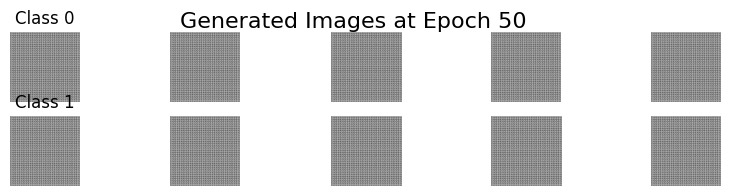

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - c_contrast_loss: 7.4506e-09 - c_loss: -52196.2969 - c_wgan_loss: -52196.2969 - g_loss: -44902.2578   
Epoch 51/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - c_contrast_loss: 5.5879e-09 - c_loss: -54089.2852 - c_wgan_loss: -54089.2852 - g_loss: -46579.4844
Epoch 52/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - c_contrast_loss: 1.8626e-08 - c_loss: -56040.3203 - c_wgan_loss: -56040.3203 - g_loss: -48244.3750
Epoch 53/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - c_contrast_loss: 1.6764e-08 - c_loss: -58025.0859 - c_wgan_loss: -58025.0859 - g_loss: -49999.4531
Epoch 54/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - c_contrast_loss: 9.3132e-09 - c_loss: -59977.3125 - c_wgan_loss: -59977.3125 - g_loss: -51771.3984
Epoch 55/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - c_contrast_loss: 1.3039e-08 - c_loss: -62104.5469 - c_wgan_loss: -62104.5469 - g_loss: -53578.4609
Epoch 56/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - c_contrast_loss: 1.6764e-08 - c_loss: -64

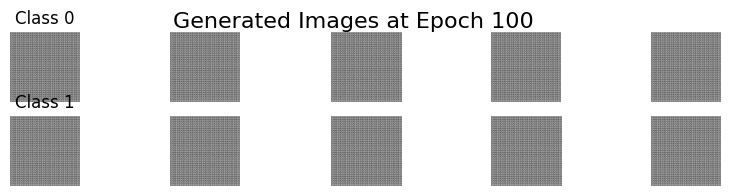

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step - c_contrast_loss: 0.0000e+00 - c_loss: -194279.9844 - c_wgan_loss: -194279.9844 - g_loss: -170526.8906
Epoch 101/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - c_contrast_loss: 0.0000e+00 - c_loss: -198112.5625 - c_wgan_loss: -198112.5625 - g_loss: -173947.5781
Epoch 102/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - c_contrast_loss: 1.8626e-09 - c_loss: -202014.6719 - c_wgan_loss: -202014.6719 - g_loss: -177452.6719
Epoch 103/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - c_contrast_loss: 7.4506e-09 - c_loss: -206051.0312 - c_wgan_loss: -206051.0312 - g_loss: -180968.5312
Epoch 104/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - c_contrast_loss: 9.3132e-09 - c_loss: -209682.6562 - c_wgan_loss: -209682.6562 - g_loss: -184529.0156
Epoch 105/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - c_contrast_loss: 9.3132e-09 - c_loss: -213516.0156 - c_wgan_loss: -213516.0156 - g_loss: -188040.5625
Epoch 106/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - c_contrast_loss: 

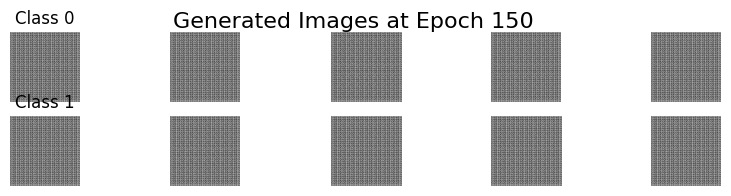

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step - c_contrast_loss: 5.5879e-09 - c_loss: -442928.2812 - c_wgan_loss: -442928.2812 - g_loss: -393581.9375
Epoch 151/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - c_contrast_loss: 7.4506e-09 - c_loss: -448430.3125 - c_wgan_loss: -448430.3125 - g_loss: -399058.5000
Epoch 152/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - c_contrast_loss: 1.1176e-08 - c_loss: -454881.8125 - c_wgan_loss: -454881.8125 - g_loss: -404469.3750
Epoch 153/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - c_contrast_loss: 3.7253e-09 - c_loss: -460258.4688 - c_wgan_loss: -460258.4688 - g_loss: -410105.2500
Epoch 154/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - c_contrast_loss: 1.1176e-08 - c_loss: -467763.8438 - c_wgan_loss: -467763.8438 - g_loss: -416023.1250
Epoch 155/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - c_contrast_loss: 3.7253e-09 - c_loss: -474345.9062 - c_wgan_loss: -474345.9062 - g_loss: -421889.2500
Epoch 156/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - c_contrast_loss: 

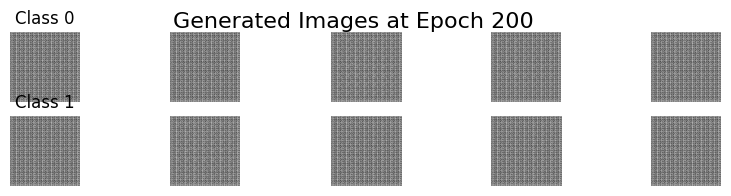

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step - c_contrast_loss: 1.1176e-08 - c_loss: -813001.2500 - c_wgan_loss: -813001.2500 - g_loss: -730117.8125
Epoch 201/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - c_contrast_loss: 7.4506e-09 - c_loss: -822123.5000 - c_wgan_loss: -822123.5000 - g_loss: -738189.5000
Epoch 202/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - c_contrast_loss: 3.7253e-09 - c_loss: -832086.8750 - c_wgan_loss: -832086.8750 - g_loss: -746373.0000
Epoch 203/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - c_contrast_loss: 1.8626e-09 - c_loss: -840315.2500 - c_wgan_loss: -840315.2500 - g_loss: -754172.6250
Epoch 204/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - c_contrast_loss: 9.3132e-09 - c_loss: -848257.5000 - c_wgan_loss: -848257.5000 - g_loss: -762218.6875
Epoch 205/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - c_contrast_loss: 1.1176e-08 - c_loss: -858233.6250 - c_wgan_loss: -858233.6250 - g_loss: -770312.3750
Epoch 206/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - c_contrast_loss: 

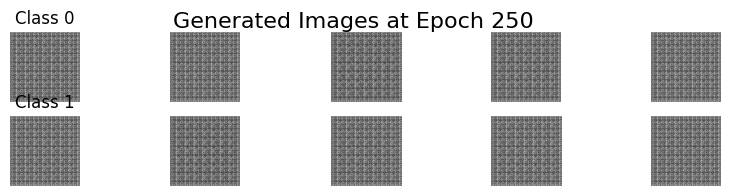

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step - c_contrast_loss: 1.4901e-08 - c_loss: -1322124.8750 - c_wgan_loss: -1322124.8750 - g_loss: -1196546.0000
Epoch 251/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - c_contrast_loss: 1.8626e-09 - c_loss: -1335601.6250 - c_wgan_loss: -1335601.6250 - g_loss: -1207040.0000
Epoch 252/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - c_contrast_loss: 0.0000e+00 - c_loss: -1349055.1250 - c_wgan_loss: -1349055.1250 - g_loss: -1218167.3750
Epoch 253/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - c_contrast_loss: 1.1176e-08 - c_loss: -1358930.7500 - c_wgan_loss: -1358930.7500 - g_loss: -1229030.8750
Epoch 254/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - c_contrast_loss: 1.1176e-08 - c_loss: -1368404.5000 - c_wgan_loss: -1368404.5000 - g_loss: -1239232.5000
Epoch 255/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - c_contrast_loss: 5.5879e-09 - c_loss: -1382247.8750 - c_wgan_loss: -1382247.8750 - g_loss: -1250115.5000
Epoch 256/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step -

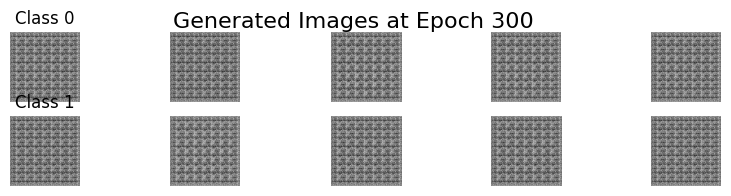

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step - c_contrast_loss: 1.3039e-08 - c_loss: -1990597.0000 - c_wgan_loss: -1990597.0000 - g_loss: -1809186.7500
Epoch 301/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - c_contrast_loss: 9.3132e-09 - c_loss: -2005787.1250 - c_wgan_loss: -2005787.1250 - g_loss: -1822375.7500
Epoch 302/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - c_contrast_loss: 3.7253e-09 - c_loss: -2018755.3750 - c_wgan_loss: -2018755.3750 - g_loss: -1836720.7500
Epoch 303/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - c_contrast_loss: 9.3132e-09 - c_loss: -2034106.2500 - c_wgan_loss: -2034106.2500 - g_loss: -1849255.3750
Epoch 304/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step - c_contrast_loss: 5.5879e-09 - c_loss: -2046187.5000 - c_wgan_loss: -2046187.5000 - g_loss: -1862101.2500
Epoch 305/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - c_contrast_loss: 9.3132e-09 - c_loss: -2064400.0000 - c_wgan_loss: -2064400.0000 - g_loss: -1878444.1250
Epoch 306/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step -

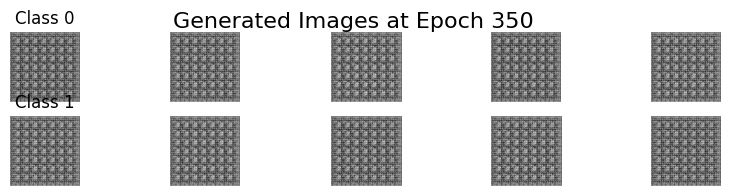

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step - c_contrast_loss: 7.4506e-09 - c_loss: -2819738.2500 - c_wgan_loss: -2819738.2500 - g_loss: -2576005.0000
Epoch 351/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - c_contrast_loss: 1.6764e-08 - c_loss: -2837129.5000 - c_wgan_loss: -2837129.5000 - g_loss: -2597493.5000
Epoch 352/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step - c_contrast_loss: 1.3039e-08 - c_loss: -2861683.5000 - c_wgan_loss: -2861683.5000 - g_loss: -2615169.2500
Epoch 353/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - c_contrast_loss: 1.8626e-09 - c_loss: -2883928.2500 - c_wgan_loss: -2883928.2500 - g_loss: -2633598.0000
Epoch 354/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - c_contrast_loss: 1.1176e-08 - c_loss: -2890667.0000 - c_wgan_loss: -2890667.0000 - g_loss: -2650532.0000
Epoch 355/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - c_contrast_loss: 7.4506e-09 - c_loss: -2912714.2500 - c_wgan_loss: -2912714.2500 - g_loss: -2667070.2500
Epoch 356/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step -

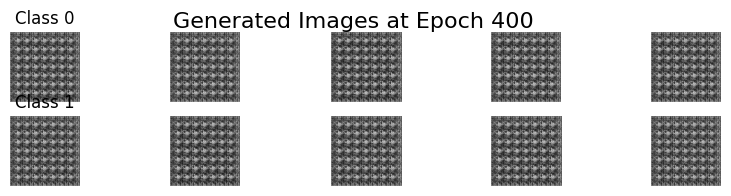

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step - c_contrast_loss: 1.3039e-08 - c_loss: -3820294.5000 - c_wgan_loss: -3820294.5000 - g_loss: -3521621.0000
Epoch 401/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - c_contrast_loss: 1.3039e-08 - c_loss: -3854084.0000 - c_wgan_loss: -3854084.0000 - g_loss: -3522153.7500
Epoch 402/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - c_contrast_loss: 1.6764e-08 - c_loss: -3874385.0000 - c_wgan_loss: -3874385.0000 - g_loss: -3555857.2500
Epoch 403/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - c_contrast_loss: 1.1176e-08 - c_loss: -3897219.2500 - c_wgan_loss: -3897219.2500 - g_loss: -3583433.5000
Epoch 404/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - c_contrast_loss: 1.4901e-08 - c_loss: -3895434.2500 - c_wgan_loss: -3895434.2500 - g_loss: -3582992.7500
Epoch 405/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - c_contrast_loss: 1.4901e-08 - c_loss: -3937952.5000 - c_wgan_loss: -3937952.5000 - g_loss: -3620647.0000
Epoch 406/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step -

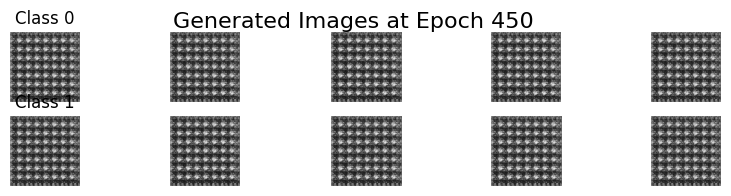

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step - c_contrast_loss: 9.3132e-09 - c_loss: -5019636.0000 - c_wgan_loss: -5019636.0000 - g_loss: -4606197.0000
Epoch 451/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - c_contrast_loss: 1.4901e-08 - c_loss: -5030885.0000 - c_wgan_loss: -5030885.0000 - g_loss: -4531681.0000
Epoch 452/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - c_contrast_loss: 7.4506e-09 - c_loss: -5051997.0000 - c_wgan_loss: -5051997.0000 - g_loss: -4634626.0000
Epoch 453/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - c_contrast_loss: 1.1176e-08 - c_loss: -5085572.0000 - c_wgan_loss: -5085572.0000 - g_loss: -4658753.0000
Epoch 454/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - c_contrast_loss: 9.3132e-09 - c_loss: -5122961.0000 - c_wgan_loss: -5122961.0000 - g_loss: -4676097.0000
Epoch 455/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - c_contrast_loss: 3.7253e-09 - c_loss: -5134924.0000 - c_wgan_loss: -5134924.0000 - g_loss: -4707955.0000
Epoch 456/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step -

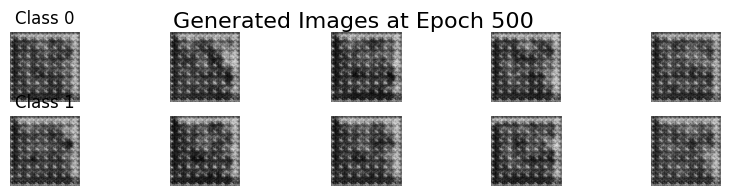

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step - c_contrast_loss: 1.4901e-08 - c_loss: -6418801.0000 - c_wgan_loss: -6418801.0000 - g_loss: -5930631.5000
Epoch 501/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - c_contrast_loss: 1.4901e-08 - c_loss: -6351314.0000 - c_wgan_loss: -6351314.0000 - g_loss: -5979314.0000
Epoch 502/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - c_contrast_loss: 9.3132e-09 - c_loss: -6483967.0000 - c_wgan_loss: -6483967.0000 - g_loss: -6012161.0000
Epoch 503/800
1/1 ━━━━━━━━━━━━━━━━━━━━ -2s -2037843us/step - c_contrast_loss: 7.4506e-09 - c_loss: -6525492.0000 - c_wgan_loss: -6525492.0000 - g_loss: -6055699.5000
Epoch 504/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - c_contrast_loss: 1.4901e-08 - c_loss: -6568194.0000 - c_wgan_loss: -6568194.0000 - g_loss: -6075877.0000
Epoch 505/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - c_contrast_loss: 1.1176e-08 - c_loss: -6502267.0000 - c_wgan_loss: -6502267.0000 - g_loss: -6105605.0000
Epoch 506/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/

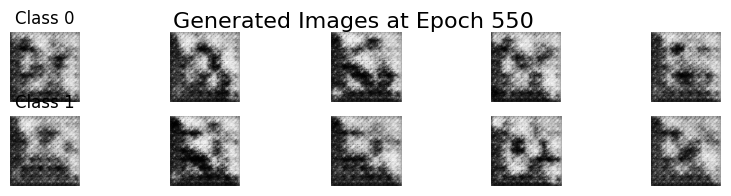

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 874ms/step - c_contrast_loss: 5.5879e-09 - c_loss: -7771189.0000 - c_wgan_loss: -7771189.0000 - g_loss: -7426019.0000
Epoch 551/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - c_contrast_loss: 5.5879e-09 - c_loss: -8015242.5000 - c_wgan_loss: -8015242.5000 - g_loss: -7488913.0000
Epoch 552/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - c_contrast_loss: 9.3132e-09 - c_loss: -8043562.0000 - c_wgan_loss: -8043562.0000 - g_loss: -7491368.0000
Epoch 553/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - c_contrast_loss: -1.8626e-09 - c_loss: -8028246.0000 - c_wgan_loss: -8028246.0000 - g_loss: -7507942.0000
Epoch 554/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - c_contrast_loss: 7.4506e-09 - c_loss: -8114742.0000 - c_wgan_loss: -8114742.0000 - g_loss: -7597064.0000
Epoch 555/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step - c_contrast_loss: 1.4901e-08 - c_loss: -8199498.5000 - c_wgan_loss: -8199498.5000 - g_loss: -7636186.0000
Epoch 556/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step 

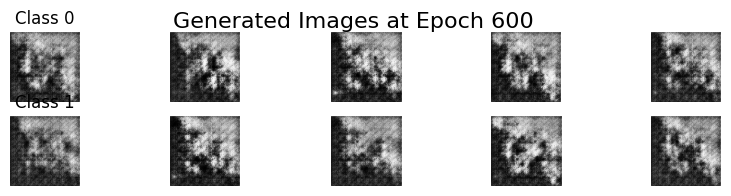

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step - c_contrast_loss: 1.6764e-08 - c_loss: -9868416.0000 - c_wgan_loss: -9868416.0000 - g_loss: -9076500.0000
Epoch 601/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - c_contrast_loss: 1.8626e-08 - c_loss: -9578066.0000 - c_wgan_loss: -9578066.0000 - g_loss: -9077188.0000
Epoch 602/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - c_contrast_loss: 1.1176e-08 - c_loss: -9958493.0000 - c_wgan_loss: -9958493.0000 - g_loss: -9322880.0000
Epoch 603/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - c_contrast_loss: 5.5879e-09 - c_loss: -9955150.0000 - c_wgan_loss: -9955150.0000 - g_loss: -9386010.0000
Epoch 604/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - c_contrast_loss: 5.5879e-09 - c_loss: -10087910.0000 - c_wgan_loss: -10087910.0000 - g_loss: -9417406.0000
Epoch 605/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - c_contrast_loss: 3.7253e-09 - c_loss: -10073879.0000 - c_wgan_loss: -10073879.0000 - g_loss: -9465059.0000
Epoch 606/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/st

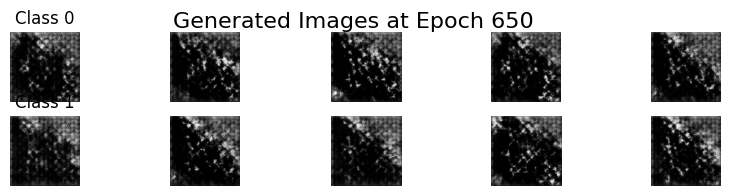

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step - c_contrast_loss: 1.1176e-08 - c_loss: -12048143.0000 - c_wgan_loss: -12048143.0000 - g_loss: -11271020.0000
Epoch 651/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - c_contrast_loss: 1.6764e-08 - c_loss: -12059812.0000 - c_wgan_loss: -12059812.0000 - g_loss: -11218062.0000
Epoch 652/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - c_contrast_loss: 7.4506e-09 - c_loss: -12100225.0000 - c_wgan_loss: -12100225.0000 - g_loss: -11373705.0000
Epoch 653/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - c_contrast_loss: 1.3039e-08 - c_loss: -12218278.0000 - c_wgan_loss: -12218278.0000 - g_loss: -11434701.0000
Epoch 654/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - c_contrast_loss: 9.3132e-09 - c_loss: -12099811.0000 - c_wgan_loss: -12099811.0000 - g_loss: -11354380.0000
Epoch 655/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - c_contrast_loss: 1.3039e-08 - c_loss: -12328441.0000 - c_wgan_loss: -12328441.0000 - g_loss: -11523870.0000
Epoch 656/800
1/1 ━━━━━━━━━━━━━━━━━━

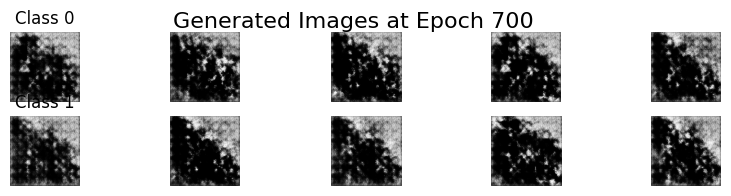

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step - c_contrast_loss: 1.1176e-08 - c_loss: -14452881.0000 - c_wgan_loss: -14452881.0000 - g_loss: -13570964.0000
Epoch 701/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - c_contrast_loss: 9.3132e-09 - c_loss: -14333719.0000 - c_wgan_loss: -14333719.0000 - g_loss: -13709167.0000
Epoch 702/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - c_contrast_loss: 3.7253e-09 - c_loss: -13531875.0000 - c_wgan_loss: -13531875.0000 - g_loss: -13536955.0000
Epoch 703/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - c_contrast_loss: 1.1176e-08 - c_loss: -14610231.0000 - c_wgan_loss: -14610231.0000 - g_loss: -13788094.0000
Epoch 704/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - c_contrast_loss: 1.1176e-08 - c_loss: -14708658.0000 - c_wgan_loss: -14708658.0000 - g_loss: -13875191.0000
Epoch 705/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - c_contrast_loss: 1.3039e-08 - c_loss: -14761393.0000 - c_wgan_loss: -14761393.0000 - g_loss: -13934236.0000
Epoch 706/800
1/1 ━━━━━━━━━━━━━━━━━━

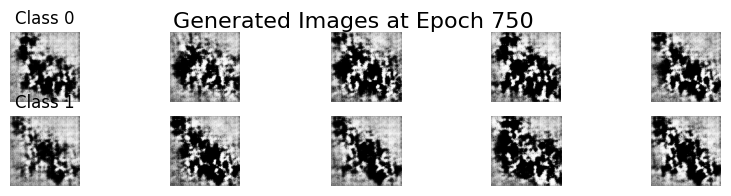

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step - c_contrast_loss: 5.5879e-09 - c_loss: -14334322.0000 - c_wgan_loss: -14334322.0000 - g_loss: -15403978.0000
Epoch 751/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - c_contrast_loss: 2.2204e-16 - c_loss: -13984879.0000 - c_wgan_loss: -13984879.0000 - g_loss: -12820060.0000
Epoch 752/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - c_contrast_loss: 7.4506e-09 - c_loss: -13717852.0000 - c_wgan_loss: -13717852.0000 - g_loss: -14713760.0000
Epoch 753/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - c_contrast_loss: 5.5879e-09 - c_loss: -15435022.0000 - c_wgan_loss: -15435022.0000 - g_loss: -15578569.0000
Epoch 754/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - c_contrast_loss: 7.4506e-09 - c_loss: -15980057.0000 - c_wgan_loss: -15980057.0000 - g_loss: -15873585.0000
Epoch 755/800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - c_contrast_loss: 3.7253e-09 - c_loss: -16360017.0000 - c_wgan_loss: -16360017.0000 - g_loss: -15965050.0000
Epoch 756/800
1/1 ━━━━━━━━━━━━━━━━━━

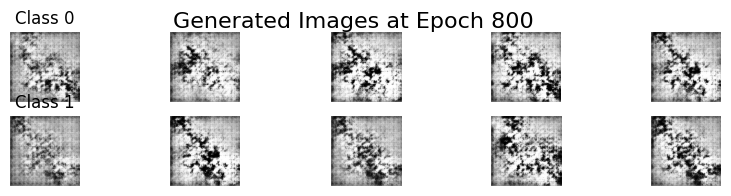

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step - c_contrast_loss: 2.4214e-08 - c_loss: -20126754.0000 - c_wgan_loss: -20126754.0000 - g_loss: -19182456.0000
Training finished.


In [9]:
# Cell 9: Image Generation Callback
class ImageCallback(keras.callbacks.Callback):
    def __init__(self, num_samples=10, latent_dim=128, num_classes=2):
        self.num_samples = num_samples
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        # Create persistent noise and labels to see how generation evolves
        self.noise = tf.random.normal([self.num_samples, self.latent_dim])
        self.labels = tf.constant([[i % self.num_classes] for i in range(self.num_samples)])

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 50 == 0:
            generated_images = self.model.generator([self.noise, self.labels])
            # Rescale images from [-1, 1] to [0, 1]
            generated_images = (generated_images + 1) / 2.0

            fig, axes = plt.subplots(self.num_classes, self.num_samples // self.num_classes, figsize=(10, 2))
            for i, img in enumerate(generated_images):
                row = i // (self.num_samples // self.num_classes)
                col = i % (self.num_samples // self.num_classes)
                axes[row, col].imshow(img[:, :, 0], cmap='gray')
                axes[row, col].axis('off')
                if col == 0:
                    axes[row, col].set_title(f'Class {row}')

            fig.suptitle(f'Generated Images at Epoch {epoch+1}', fontsize=16)
            plt.show()

# Cell 10: Compile and Train
# The paper uses RMSProp [cite: 266]
g_optimizer = keras.optimizers.RMSprop(learning_rate=LEARNING_RATE)
c_optimizer = keras.optimizers.RMSprop(learning_rate=LEARNING_RATE)

cgan = CGAN(
    generator=generator,
    critic=critic,
    latent_dim=LATENT_DIM,
    num_classes=NUM_CLASSES,
    critic_updates=CRITIC_UPDATES,
    contrastive_loss_weight=CONTRASTIVE_LOSS_WEIGHT,
    contrastive_temp=CONTRASTIVE_TEMP
)

cgan.compile(g_optimizer=g_optimizer, c_optimizer=c_optimizer)

print("Starting training...")
cgan.fit(
    train_dataset,
    epochs=EPOCHS,
    callbacks=[ImageCallback(num_samples=10, latent_dim=LATENT_DIM, num_classes=NUM_CLASSES)]
)
print("Training finished.")

Generating final sample images from the trained model...


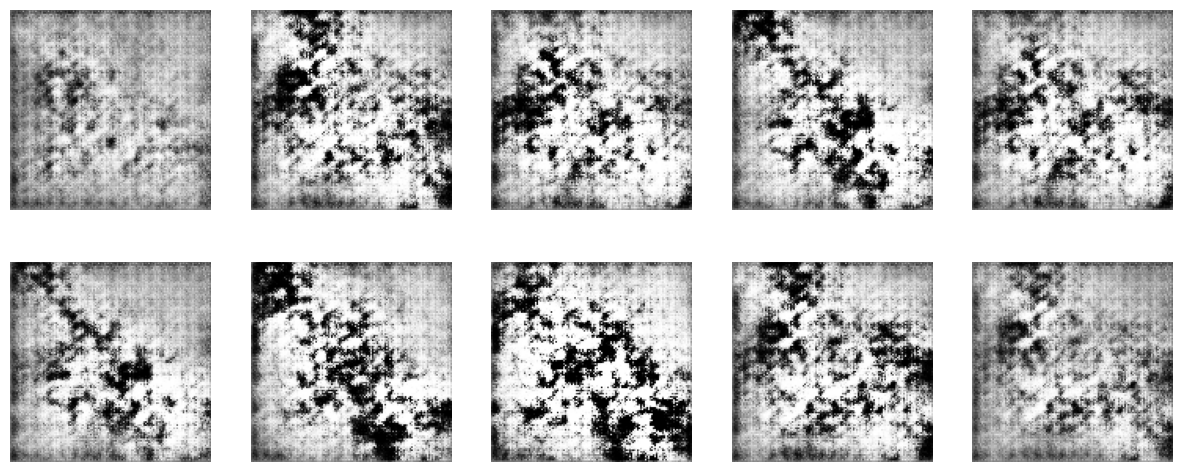

In [10]:
# Cell 11: Final Generation and Visualization
def generate_and_plot_images(generator_model, num_images_per_class=5):
    fig, axes = plt.subplots(NUM_CLASSES, num_images_per_class, figsize=(15, 6))
    class_names = ['As-cast', 'Deformed (800C, 0.001/s)']
    
    for i in range(NUM_CLASSES):
        noise = tf.random.normal([num_images_per_class, LATENT_DIM])
        labels = tf.ones([num_images_per_class, 1], dtype=tf.int32) * i
        
        generated_images = generator_model([noise, labels])
        generated_images = (generated_images + 1) / 2.0 # Rescale to [0,1]
        
        for j in range(num_images_per_class):
            axes[i, j].imshow(generated_images[j, :, :, 0], cmap='gray')
            axes[i, j].axis('off')
        axes[i, 0].set_ylabel(class_names[i], fontsize=12)
        
    plt.show()

print("Generating final sample images from the trained model...")
generate_and_plot_images(cgan.generator)

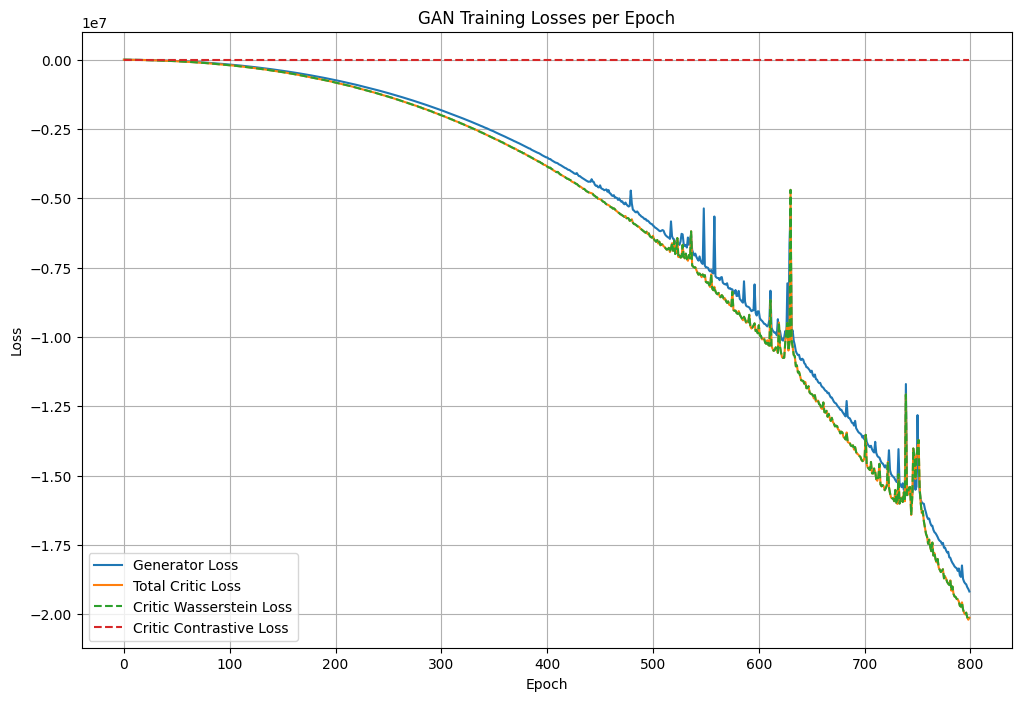

In [11]:
# Cell 12: Plotting the Loss Curves

# The 'cgan.fit' method returns a History object. Let's capture it.
# If you already ran training, you'll need to re-run it like this:
# history = cgan.fit(...)

# For demonstration, let's assume 'history' is the variable holding the training history.
# If you don't want to retrain, you can access it via the model's history attribute
# if it was the last model trained in the session.
history = cgan.history

# --- Plotting ---
plt.figure(figsize=(12, 8))

# Plot Generator Loss
plt.plot(history.history['g_loss'], label='Generator Loss')

# Plot Critic Losses
plt.plot(history.history['c_loss'], label='Total Critic Loss')
plt.plot(history.history['c_wgan_loss'], label='Critic Wasserstein Loss', linestyle='--')
plt.plot(history.history['c_contrast_loss'], label='Critic Contrastive Loss', linestyle='--')

plt.title('GAN Training Losses per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# Cell 13: Visualize the Generator Architecture
from tensorflow.keras.utils import plot_model

plot_model(
    generator,
    to_file='generator_plot.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB', # 'TB' for top-to-bottom, 'LR' for left-to-right
    expand_nested=True,
    dpi=96
)

print("Generator architecture saved to generator_plot.png")

You must install pydot (`pip install pydot`) for `plot_model` to work.
Generator architecture saved to generator_plot.png


In [15]:
# Cell 14: Visualize the Critic Architecture
plot_model(
    critic,
    to_file='critic_plot.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=96
)

print("Critic architecture saved to critic_plot.png")

You must install pydot (`pip install pydot`) for `plot_model` to work.
Critic architecture saved to critic_plot.png


In [16]:
# Cell 15: Print Model Summaries

print("="*50)
print("Generator Architecture")
print("="*50)
generator.summary()

print("\n\n" + "="*50)
print("Critic Architecture")
print("="*50)
critic.summary()

Generator Architecture


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ label_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 128)    │        256 │ label_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ noise_input         │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 128)       │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 128)       │          0 │ noise_input[0][0… │
│                     │                   │            │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 8192)      │  1,048,576 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 4, 4, 512) │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 8, 8, 256) │  2,097,152 │ reshape[0][0]     │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 8, 8, 256) │      1,024 │ conv2d_transpose… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 8, 8, 256) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 16, 16,    │    524,288 │ leaky_re_lu[0][0] │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 32, 32,    │    131,072 │ leaky_re_lu_1[0]… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ self_attention      │ (None, 32, 32,    │      5,120 │ leaky_re_lu_2[0]… │
│ (SelfAttention)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_3  │ (None, 64, 64,    │     32,768 │ self_attention[0

 Total params: 3,841,664 (14.65 MB)

 Trainable params: 3,840,704 (14.65 MB)

 Non-trainable params: 960 (3.75 KB)



Critic Architecture


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │      1,088 │ image_input[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    131,072 │ leaky_re_lu_4[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_5       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │    524,288 │ leaky_re_lu_5[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      1,024 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_6       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 8, 8, 512) │  2,097,152 │ leaky_re_lu_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 512) │      2,048 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 1, 64)     │        128 │ label_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_7       │ (None, 8, 8, 512) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 8, 8, 1)   │          0 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 8, 8, 513) │          0 │ leaky_re_lu_7[0]… │
│ (Concatenate)       │                   │            │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 4, 4, 512) │  4,203,008 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_8       │ (None, 4, 4, 512) │          0 │ conv2d_8[0][0]  

 Total params: 15,423,745 (58.84 MB)

 Trainable params: 15,421,953 (58.83 MB)

 Non-trainable params: 1,792 (7.00 KB)

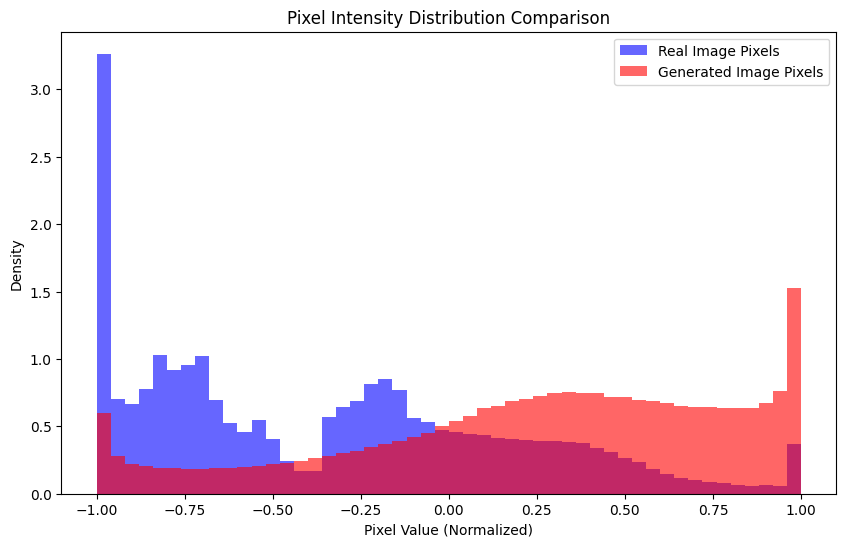

In [17]:
# Cell 16: Plotting Pixel Intensity Distributions

# 1. Get a batch of real images from your dataset
real_images, _ = next(iter(train_dataset))

# 2. Generate a batch of fake images
noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])
# Let's generate images for class 1 (deformed) for this example
labels = tf.ones([BATCH_SIZE, 1], dtype=tf.int32)
generated_images = cgan.generator([noise, labels])

# 3. Flatten the image arrays to get pixel values
real_pixels = real_images.numpy().flatten()
generated_pixels = generated_images.numpy().flatten()

# 4. Plot the histograms
plt.figure(figsize=(10, 6))
plt.hist(real_pixels, bins=50, color='blue', alpha=0.6, label='Real Image Pixels', density=True)
plt.hist(generated_pixels, bins=50, color='red', alpha=0.6, label='Generated Image Pixels', density=True)
plt.title('Pixel Intensity Distribution Comparison')
plt.xlabel('Pixel Value (Normalized)')
plt.ylabel('Density')
plt.legend()
plt.show()

2025-10-07 11:50:09.752147: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.23GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


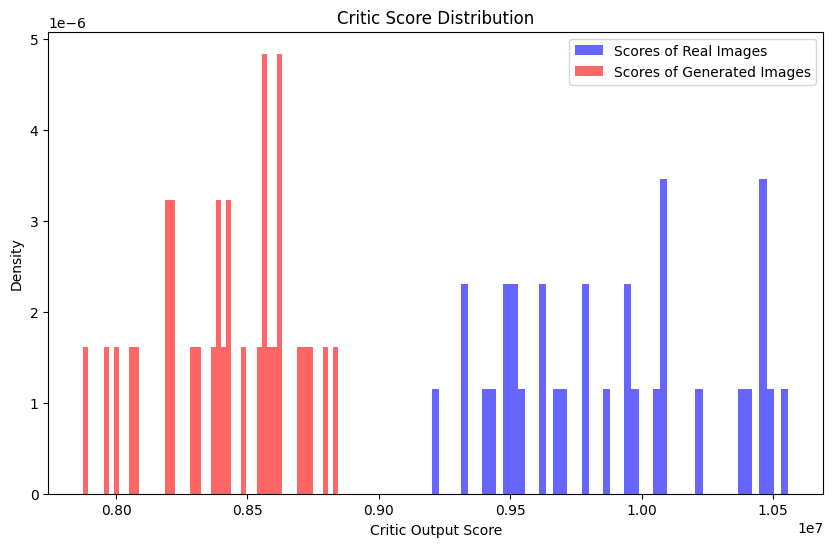

Average score for real images: 9871769.00
Average score for fake images: 8417998.00


In [18]:
# Cell 17: Plotting Critic Score Distributions

# We can reuse the real and generated images from the previous cell
# 1. Get scores from the critic for both real and generated images
real_scores, _ = cgan.critic([real_images, labels])
generated_scores, _ = cgan.critic([generated_images, labels])

# 2. Plot the histograms of the scores
plt.figure(figsize=(10, 6))
plt.hist(real_scores.numpy(), bins=50, color='blue', alpha=0.6, label='Scores of Real Images', density=True)
plt.hist(generated_scores.numpy(), bins=50, color='red', alpha=0.6, label='Scores of Generated Images', density=True)
plt.title('Critic Score Distribution')
plt.xlabel('Critic Output Score')
plt.ylabel('Density')
plt.legend()
plt.show()

print(f"Average score for real images: {np.mean(real_scores):.2f}")
print(f"Average score for fake images: {np.mean(generated_scores):.2f}")

In [19]:
# Cell 18: Save the Generator Model

# The generator is an attribute of our trained CGAN model
generator_to_save = cgan.generator

# Save the generator to a file. The '.keras' format is the modern, recommended format.
generator_to_save.save('cgan_generator.keras')

print("Generator model saved to cgan_generator.keras")

Generator model saved to cgan_generator.keras


In [21]:
# Cell 19: Save Model Weights

# Save the generator's weights
cgan.generator.save_weights('cgan_generator_weights.weights.h5')

# You can also save the critic's weights if you want to resume training later
cgan.critic.save_weights('cgan_critic_weights.weights.h5')

print("Generator weights saved to cgan_generator_weights.weights.h5")
print("Critic weights saved to cgan_critic_weights.weights.h5")

Generator weights saved to cgan_generator_weights.weights.h5
Critic weights saved to cgan_critic_weights.weights.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


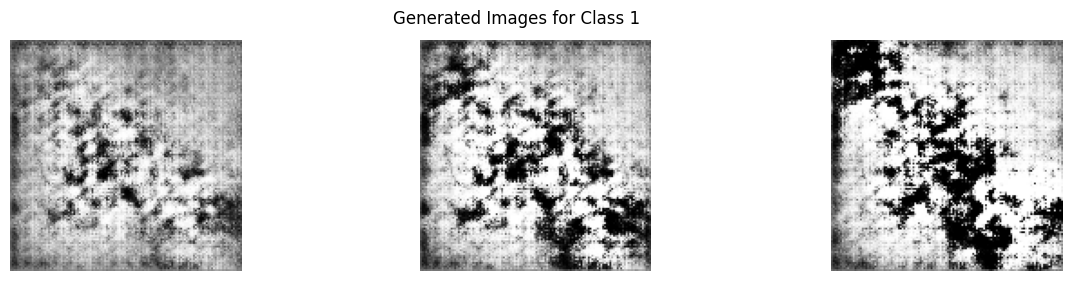

In [12]:
# In a new script or notebook:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load the saved generator model
# No need for the original code that built the model
loaded_generator = tf.keras.models.load_model(
    './models/cgan_generator.keras',
    custom_objects={'SelfAttention': SelfAttention} # IMPORTANT: Tell Keras about your custom layer
)

# --- Now you can use it ---
LATENT_DIM = 128 # Make sure this matches the dimension used during training

def generate_images_with_loaded_model(model, num_images, class_label):
    noise = tf.random.normal([num_images, LATENT_DIM])
    labels = tf.ones([num_images, 1], dtype=tf.int32) * class_label
    
    generated_images = model.predict([noise, labels])
    generated_images = (generated_images + 1) / 2.0 # Rescale to [0,1] for plotting
    
    # Plot the images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        axes[i].imshow(generated_images[i, :, :, 0], cmap='gray')
        axes[i].axis('off')
    plt.suptitle(f"Generated Images for Class {class_label}")
    plt.show()

# Generate some "deformed" microstructures (Class 1)
generate_images_with_loaded_model(loaded_generator, num_images=3, class_label=1)